In [1]:
import math
import cairo
import matplotlib.pyplot as plt

from io import BytesIO
import IPython.display

In [2]:
def hue2rgb(p, q, t):
    if (t < 0): t += 1
    if (t > 1): t -= 1

    if (t < 1/6): return p + (q - p) * 6 * t
    if (t < 1/2): return q
    if (t < 2/3): return p + (q - p) * (2/3 - t) * 6

    return p

# Converts an HSL color value to RGB. Conversion formula
# adapted from http://en.wikipedia.org/wiki/HSL_color_space.
# Assumes h, s, and l are contained in the set [0, 1] and
# returns r, g, and b in the set [0, 1].
# See: https://stackoverflow.com/questions/2353211/hsl-to-rgb-color-conversion
def convertHslToRgb(h, s, l):
    if (s == 0):
        r = g = b = l # achromatic
    else:
        if l < 0.5:
            q = l * (1 + s)
        else:
            q = l + s - l * s

        p = 2 * l - q
        r = hue2rgb(p, q, h + 1/3)
        g = hue2rgb(p, q, h)
        b = hue2rgb(p, q, h - 1/3)
    return r, g, b

# Converts an RGB color value to HSL. Conversion formula
# adapted from http://en.wikipedia.org/wiki/HSL_color_space.
# Assumes r, g, and b are contained in the set [0, 1] and
# returns h, s, and l in the set [0, 1].
# See: https://stackoverflow.com/questions/2353211/hsl-to-rgb-color-conversion
def convertRgbToHsl(r, g, b):
    max_rgb_idx, max_rgb = max(enumerate((r, g, b)), key=operator.itemgetter(1))
    min_rgb = min(r, g, b)
    l = (max + min) / 2

    if (max_rgb == min_rgb):
        h = s = 0 # achromatic
    else:
        d = max_rgb - min_rgb
        if l >= 0.5:
            s = d / (2 - (max + min))
        else:
            d / (max_rgb + min_rgb)
        if max_rgb_idx == 0: # r
            h = ((g - b) / d + 0) * 60
        elif max_rgb_idx == 1: # g
            h = ((b - r) / d + 2) * 60
        else: # b
            h = ((r - g) / d + 4) * 60
    return h, s, l

convertHslToRgb(0.5, 0.5, 0.5)

(0.25, 0.7499999999999999, 0.75)

In [3]:
def getNotePosition(diff_n):
    x_base = -3 * diff_n
    y_base = 4 * diff_n
    d_base = 7 * diff_n
    k = math.ceil(10000 + (d_base - 12) / 24) - 10000
    x = x_base + 12 * k
    y = y_base - 12 * k
    d = y - x
    return (x, y)

def getFreqPosition(f, f0=440):
    diff_n = math.log(f/f0)/math.log(math.pow(2,1/12))
    return getNotePosition(diff_n)

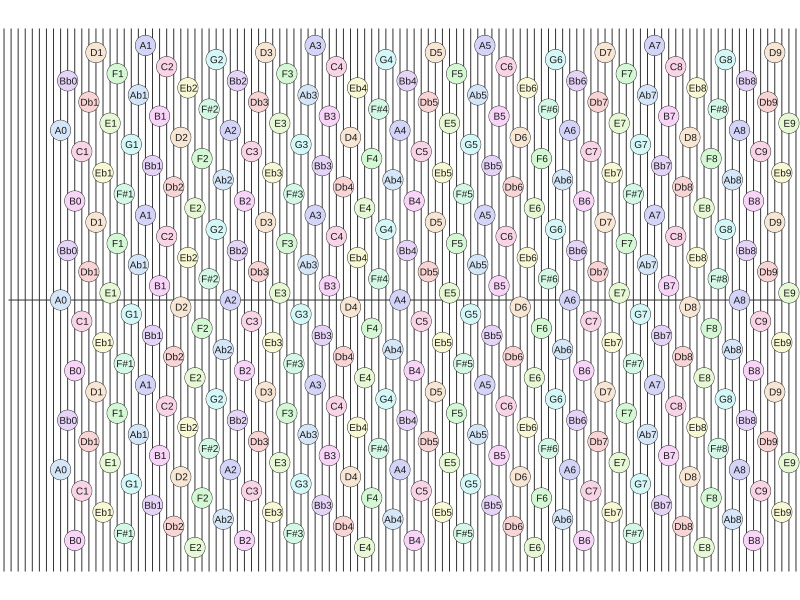

In [20]:
notes_data = {}
note_names = ['C', 'Db', 'D', 'Eb', 'E', 'F', 'F#', 'G', 'Ab', 'A', 'Bb', 'B']

for note in range(21, 128):
    note_class = note % 12
    octave = note // 12 - 1
    name = f"{note_names[note_class]}{octave}"
    freq = 440 * math.pow(2, (note - 69)/12)
    xpos, ypos = getNotePosition(note - 69)
    notes_data[note] = (name, freq, xpos, - ypos)

width, height = 800, 600

ang = -math.pi/4
scale = 10
cang = scale * math.cos(ang)
sang = scale * math.sin(ang)
radius = 10

equitonal_dx = cang * 12 - sang * 12
equitonal_dy = cang * 12 + sang * 12

ixy_list = [
    (0, 0),
    (equitonal_dy, equitonal_dx),
    (-equitonal_dy, -equitonal_dx),
]

with BytesIO() as svgio:
    surface = cairo.SVGSurface(svgio, width, height)
    ctx = cairo.Context(surface)

    ctx.save()

    ctx.select_font_face("Arial", cairo.FONT_SLANT_NORMAL, cairo.FONT_WEIGHT_NORMAL)
    ctx.set_font_size(10)
    
    n = height / equitonal_dy / 2 - 0.05
    m = width / equitonal_dx / 2 - 0.05
    if width / equitonal_dx < height / equitonal_dy:
        n, m = m, n

    ctx.set_line_width(1)
    ctx.set_source_rgb(0.2, 0.2, 0.2)
    ctx.move_to(width/2 - equitonal_dx * n, height/2 + equitonal_dy * n)
    ctx.line_to(width/2 + equitonal_dx * n, height/2 - equitonal_dy * n)

    ctx.set_line_width(1)
    ctx.set_source_rgb(0.5, 0.5, 0.5)
    for i in range(-12 * 5, 12 * 5 + 1):
        ctx.move_to(width/2 + equitonal_dx * i / 24 + equitonal_dy * 1.6,
                    height/2 - equitonal_dy * i / 24 + equitonal_dx * 1.6)
        ctx.line_to(width/2 + equitonal_dx * i / 24 - equitonal_dy * 1.6,
                    height/2 - equitonal_dy * i / 24 - equitonal_dx * 1.6)
           
    for note, (name, freq, xpos, ypos) in notes_data.items():
        color = convertHslToRgb(note_class / 12, 0.7, 0.9)
        note_class = note % 12

        rot_xpos = width/2. + cang * xpos + sang * ypos
        rot_ypos = height/2. + cang * ypos - sang * xpos

        for ix, iy in ixy_list:
            xx = rot_xpos + ix
            yy = rot_ypos + iy

            if xx >= radius and xx < width - radius and yy >= radius and yy < height - radius:      
                ctx.move_to(xx, yy)
                ctx.set_line_width(1)
                ctx.set_source_rgb(0.2, 0.2, 0.2)
                ctx.arc(xx, yy, radius, 0, 2. * math.pi)
                ctx.stroke_preserve()
                ctx.set_source_rgb(*color)
                ctx.fill()
        
                ctx.set_source_rgb(0.1, 0.1, 0.1)
                text_extents = ctx.text_extents(name)
                ctx.move_to(xx - text_extents.width/2., yy + text_extents.height/2.)
                ctx.show_text(name)

    ctx.restore()

    pngio = BytesIO()
    surface.write_to_png(pngio)

    ctx.save()
    surface.finish()
    svg_data = svgio.getvalue()

#print(svg_data)
IPython.display.SVG(data=svg_data)
#IPython.display.Image(data=pngio.getvalue())